# Implementing the Jarvis march algorithm

*Graham Burgess - January 2023*

### Information for user

This code has been developed and tested using the python version listed below.  

In [1]:
!python -V

Python 3.9.10


### Introduction

This code implements the Jarvis march algorithm to find the convex hull of a set of points on a two-dimensional plane. 

We start with several CSV files containing x- and y- coordinates of a set of points. The goal of this notebook is to introduce a set of python classes and functions which enable the user to obtain and visualise the convex hull of the set of points in any of these CSV files. The code is adaptable so that the user can obtain results with a new CSV file containing similar data. 

First, I will introduce the Jarvis March algorithm using pseudo-code. Then, I will introduce the various classes and functions which enable the algorithm to be executed. I will then use several examples to illustrate the algorithm working, at which point I will discuss some interesting aspects of the algorithm, including the computational complexity. 

### The Jarvis march algorithm

The Jarvis march algorithm, as introduced by Jarivs (1973), is a method for efficiently identifying the convex hull of a set of points. In brief terms, it can be described as starting the convex hull at the left most point and choosing the next point on the convex hull by randomly selecting a candidate point and checking whether the candidate is more suitable than all others. During this check, if a more suitable point is idenfied, this point becomes the updated candidate. When all points have been checked, the latest candidate is established as the next point on the convex hull. This process continues until the convex hull is complete. 

### Pseudocode

Pseudocode for the algorithm was orignally given in the assessment documents. I feel that there were some merits to this pseudocode, as detailed below: 

* The first line quickly helped the user understand the setting for the algorithm to take place. 
* The algorithm was described in simple terms, making it accessible and easy to quickly understand the essence of the algorithm. 
* Numbers and letters were assigned to each step which would help someone who was writing code to implement the algorithm to quickly see the flow from step to step. 

However, I feel there were some drawbacks to the pseudocode given in the assessment documents: 

* The distinction between $p$ and the other elements of the convex hull  was not clear, further complicated by the confusing terminology "next[$p$]" which suggests some vector "next" with a $p$th element. 
* Steps 2 (b) and 2 (c) are confusing next to each other becuase two separate things are set to equal to q. "next[$p$]" is really for use outside of the loop (constructing the convex hull) whereas $p$ is needed inside the loop to construct the triplet - however because this is not specified, the difference between $p$ and "next[$p$]" is not clear. 
* It is not clear whether any point can be selected as the next point $q$ but in fact it should be any other point in the set $S$ except the last point on the convex hull. 
* Within point 2 (a) there is repetition "for any other point $r$" so it would be helpful if a "For ... Do ... End For" structure was included. 

I have therefore written a new piece of pseudocode for this algorithm. I believe that this pseudocode has maintained the merits of the provided pseudocode, and additionally has the following merits: 

* It aims to be as simple as possible, while giving the right level of detail.
* It aims to clearly label different points, lines and sets with appropriate notation
* It aims to make clear what and what cannot be selected as the next values of point $q$ and $r$. 

![JM](jm_30_Jan.png)

### Arc tangent function

The arc tangent function is the crux of my algorithm. The arctangent function, math.atan2(y,x), gives the angle between the positive X-axis and the vector from the origin to the point (x, y) (see https://docs.python.org/3/library/math.html#math.atan2). It has output values between $-\pi$ and $+\pi$ so the sign of the output gives an indication of the orientation of the points in question. 

I am interested in an ordered triplet of three points $(p,r,q)$ anywhere on the two-dimensional plane. I am interested in the angle at the second point $r$, generated by lines $\overrightarrow{rp}$ and $\overrightarrow{rq}$. I can use the arc tangent function to help resolve this, but first I must deal with the fact that $\overrightarrow{rp}$ does not necessarily lie on the positive X-axis. I am interested a point $P$ that creates a vector from the origin such that the positive X-axis and this vector have the same orientation as $\overrightarrow{rp}$ and $\overrightarrow{rq}$. I am finding the point $P$ which effectively transforms the two vectors so they have the same relative orientation but one lies on the the positive X-axis. I find the point $P$ using the dot product and cross product (i.e. determinent in two dimensions) of $\overrightarrow{rp}$ and $\overrightarrow{rq}$. The dot product indicates how much these two vectors align and the cross product indicates to what extent the two vectors are orthoganal. The point $P = (x, y) = (\overrightarrow{rp} \cdot \overrightarrow{rq}$, $\overrightarrow{rp} \times \overrightarrow{rq})$ makes the appropriate transformation. This can be seen with a simple example: Consider $(p,r,q) = ((3,2),(2,1),(1,1))$ which creates an angle of $135^{\circ}$. 

$\overrightarrow{rp} \cdot \overrightarrow{rq} = (1)(-1)+(1)(0) = -1$. 

$\overrightarrow{rp} \times \overrightarrow{rq} = (1)(0)-(1)(-1) = 1$.

The point $P = (-1,1)$ creates a vector with the origin which itself forms an angle of $135^{\circ}$ with the positive X-axis, as required. The following resource provides further explanation of this method of finding angles using math.atan2(): https://wumbo.net/formulas/angle-between-two-vectors-2d/#.

I use this method within the find_orientation() method within the triplet_of_points() class in order to find the most appropriate points to favour as candidates for points on the convex hull.

### Issues regarding collinearity

Some issues arise when three adjacent points on the convex hull are collinear. To deal with these issues it is first important to define precisely what is included in the convex hull with the following points: 

1. The convex hull of a set of points $S$ is the set of points $H \subset S$ which, when the points in $H$ are connected sequentially (including reconnecting to the start of the set), draws the smallest shape which contains all points in $S$. 
2. The convex hull $H$ starts with the leftmost point in $S$. Since it is a set in the mathematical sense, $H$ does not have any repeated elements, however it is implied that the convex hull would be drawn by starting and ending at the leftmost point. 
3. In the case of collinear points on the convex hull, all collinear points are elements of $H$. 
4. In the case of all points in $S$ being collinear, $H = S$

Following from point 1, since $S$ is a set in the mathematical sense, there are no repeated points and the code below ensures this is the case. 

Following from point 2, when there are multiple leftmost points (with the same x-coordinate) the point which appears first in the data is chosen as the start of $H$. This is arbitrary but it makes no difference to the resulting convex hull. 

To ensure point 3 is maintained, it is important to highlight the following feature of the algorithm: test points $r$ which create an angle (formed by $(p,q,r)$) of $180^{\circ}$ are favoured over test points which created an angle of $360^{\circ}$. This ensures the convex hull goes out along a set of collinear points, capturing all points along the way. 

Following from point 3, there is a special case which the algorithm must deal with when $p$ is the end of the convex hull, $q$ is a candidate on a previous point of the convex hull and $r$ is a point not on the convex hull but $r$ is collinear with ${p,q}$. It is important that point $r$ is favoured over point $q$ in this case, but since the corresponding angle is $360^{\circ}$, the algorithm must make a special exception to ensure point $r$ is favoured. 

Following from point 4 above, the algorithm checks whether all points on the hull are collinear and if they are, the convex hull is created from scratch, in knowledge of the order of collinear points. 

### Functions and classes

I now introduce the functions and classes that I have written to execute the algorithm. Each function/class contains a docstring with helpful information. Some further commenting is included in the code cells below, for clarity. It is worth noting that the analysis is run by calling the "jarvis_march" function, which itselfs calls the other functions and classes, directly or indirectly.

In [1]:
# imports
import csv
import math
import random
from plotnine import *
import pandas as pd
import time

In [2]:
# functions
def jarvis_march(csv_file_name, collect_all = True, collect_amount = 0):
    """
    Implement the Jarvis march algorithm. 

    This function reads the data from the given CSV, initialises a set of points and finds its convex hull. 
    A plot of the convex hull is returned. 
    Two timings are captured for subsequent analysis - the time for the whole function to run, and for a specific part. 

    Parameters
    ----------
    csv_file_name : str
        Name of CSV file containing (x,y) point information in two columns. This should exclude '.csv'
    collect_all : bool (default = True)
        True if all the data from this CSV file is to be read. 
    collect_ammount : int (default = 0)
        The number of rows of data to be collected if collect_all = False

    Returns
    -------
    plot : ggplot
        A plot of the set of points and its convex hull
    points : set_of_points
        The set of points of interest, including information on its convex hull
    timer : float
        The time taken to execute points.find_convex_hull()
    summary : str
        Summary of the number of points in the set and on the hull. 
    """
    
    # read points
    points = read_points(csv_file_name, collect_all, collect_amount)
    
    # timer start
    tic = time.perf_counter()
    
    # find hull
    random.seed(1)
    points.find_convex_hull()
    
    # timer end
    toc = time.perf_counter()
    timer = toc - tic
    
    # plot and summary
    plot = generate_plot(points, points.convex_hull_points, csv_file_name)
    summary = 'There are ' + str(len(points)) + ' points in the set and ' + str(len(points.convex_hull_points)) + ' points on the convex hull.'
    
    return(plot, points, timer, summary)
    
def read_points(csv_file_name, collect_all = True, collect_amount = 0):
    """
    Read points from a CSV file and initialise a 'set_of_points' object.
    If there are more than two columns of data, the rightmost two columns are read. 
    If there are empty rows of data, they are ignored and a warning flag is printed. 
    If there are rows of data with duplicate x- and y- coordinates, duplicates will not be kept

    Parameters
    ----------
    csv_file_name : str
        Name of CSV file containing (x,y) point information in two columns. This should exclude '.csv'
    collect_all : bool (default = True)
        True if all the data from this CSV file is to be read. 
    collect_ammount : int (default = 0)
        The number of rows of data to be collected if collect_all = False

    Returns
    -------
    points : set_of_points
        The set of points containing the (x,y) information from the CSV file. 
    """
    
    # open the file
    with open(csv_file_name + '.csv',mode='r') as csv_file :
        # create a reader - this allows a delimiter to be specified and used
        csv_reader = csv.reader(csv_file, delimiter=',')

        # store point data from reader
        points = list()
        ncol = len(next(csv_reader))
        csv_file.seek(0) # go to the beginning of the CSV file
        flag = None # this will be updated to a message to be printed if there are empty rows. 
        xy = [] # stores xy coords for checking for dupes
        for row in csv_reader :
            try:
                new_xy = (float(row[ncol-2]),float(row[ncol-1]))
                if new_xy not in xy:
                    xy.append(new_xy)
                    points.append(point(x = new_xy[0], y = new_xy[1]))
            except:
                if flag is None: 
                    flag = 'Warning: empty cells in input CSV'
                    print(flag)
                    
        # slice list if required
        if collect_all == False:
            points = points[0:collect_amount]
        
        # store points as 'set_of_points' object, now they will not be added to or removed from. 
        points = set_of_points(points) # change to tuple for more efficient access
        
    return(points)

def generate_plot(points, hull, csv_file_name):
    """
    Generate plot of a set of points and its convex hull.  

    This function generates dataframes from the information about the points and its hull, and creates a ggplot. 

    Parameters
    ----------
    points : set_of_points
        Set of points for which the hull has been found
    hull : set_of_points.convex_hull_points
        Information regarding the convex hull
    csv_file_name : str
        Name of CSV file containing (x,y) point information in two columns. This should exclude '.csv'

    Returns
    -------
    plot : ggplot
        A plot of the set of points and its convex hull
    """
    
    # dataframe for all points
    X_points = [point.x for point in points]
    Y_points = [point.y for point in points]
    df_points = pd.DataFrame({"X" : X_points,"Y" : Y_points, "Points" : "Remaining points"})

    # dataframe for points on convex hull
    X_hull = [point.x for point in hull]
    Y_hull = [point.y for point in hull]
    df_hull = pd.DataFrame({"X" : X_hull,"Y" : Y_hull, "Points" : "Points on convex hull"})
    
    # full dataframe
    df = pd.concat([df_points,df_hull])
    
    # plot
    p = ggplot(df,aes(x='X',y='Y'))
    p = p + geom_point(aes(color = 'Points')) 
    p = p + geom_polygon(data = df_hull, alpha = 0.1)
    p = p + ggtitle('Convex hull of points in ' + csv_file_name + '.csv')
    p = p + theme_bw()
    
    return(p)

In [3]:
# classes
class point:
    """
    A class to represent a single point on a two-dimensional plane

    Attributes
    ----------
    x : float
        x-coordinate
    y : float
        y-coordinate
        
    Methods
    -------
    None
    """
        
    def __init__(self, x = 0, y = 0):
        """
        Initialise instance of the point class

        Parameters
        ----------
        x : float
            x-coordinate
        y : float
            y-coordinate

        Returns
        -------
        None
        """
        
        self.x = x
        self.y = y

class set_of_points(tuple):
    """
    A class to represent a set of points on a two-dimensional plane
    Inherits from tuple

    Attributes
    ----------
    leftmost_val : float
        x-coordinate of the leftmost point
    leftmost_index : int
        index of the leftmost point
    convex_hull : list
        list of the indices of each point on the convex hull
    convex_hull_points : list / set_of_points
        list of the actual point objects relating to the points on the convex hull.
        this starts as a list and is made into a set_of_points in the find_convex_hull() method
    all_points_collinear : True until a triplet of points within the set is found which is not collinear. 
        
    Methods
    -------
    find_leftmost_point : 
        Finds the leftmost point in the set
    find_new_point : 
        Finds a new point random in the set
    find_convex_hull : 
        Finds the convex hull of the set of points
    """
    
    def find_convex_hull(self):
        """
        Finds the convex hull of a set of points and appends this to self.convex_hull_points.
        First this function deals with indices: 
        i.e. it finds the indices of the elements of the set which are on the convex hull. 
        It then translates these indicies into a set of points which define the convex hull. 

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        
        # set up attributes
        self.convex_hull = list() # this is a list of indices indicating which elements of the set are on the hull
        self.convex_hull_points = list() # this is a list of points from the point class
        self.all_points_collinear = True # change this if we find non-collinear points
        self.leftmost_index = None
        self.leftmost_val = float('inf')
        
        # First deal with special cases of small sets of points
        if len(self) == 0:
            print("No data points to analyse")
            
        elif len(self) == 1:
            print("Only one data point to analyse")            
            self.convex_hull_points.append(self[0])
            
        elif len(self) == 2:
            print("Only two data points to analyse")
            # add leftmost point
            self.find_leftmost_point()
            self.convex_hull_points.append(self[self.leftmost_index])
            # add rightmost point
            rightmost_index = [i for i in [0,1] if i != self.leftmost_index][0]
            self.convex_hull_points.append(self[rightmost_index])
        
        # Then deal with general case of a set of three or more points
        else: 
            self.find_leftmost_point()
            not_complete_hull = True # this will change to False once the convex hull reaches its starting point
            while not_complete_hull:
                # identify end of the current hull
                end_of_hull_index = self.convex_hull[len(self.convex_hull)-1]

                # select candidate
                candidate = self.find_new_point(exceptions = [end_of_hull_index])

                # test the candidate with test points
                points_not_to_choose = [end_of_hull_index,candidate]
                test_points = [i for i in range(0, len(self)) if i not in points_not_to_choose]
                for test_point in test_points:
                    # create new instance of triplet class from the end of the hull -> test point -> candidate
                    triplet = triplet_of_points(self[end_of_hull_index], self[test_point], self[candidate])
                    triplet.find_orientation()
                    
                    # update candidate if angle theta in the triplet from a -> b counterclockwise satisfies 0 < theta <= 180
                    if triplet.right_turn == True:
                        candidate = test_point 
                        
                    # update candidate if triplet is collinear, candidate on the convex hull but not test_point
                    # this stops the algorithm prioritising a point already on the convex hull ...
                    # ... when comparing against a collinear test point ...
                    # ... It might then have chosen a suboptimal point at the next test point, but this ensures not. 
                    if triplet.collinearity == True and candidate in self.convex_hull and test_point not in self.convex_hull[1:]:
                        candidate = test_point
                    
                    # Update instance attribute if a non-collinear triplet has been found. 
                    if triplet.collinearity == False: 
                        self.all_points_collinear = False

                # update hull
                self.convex_hull.append(candidate)

                # is the hull complete
                if self.convex_hull[len(self.convex_hull)-1] in self.convex_hull[0:len(self.convex_hull)-1]:
                    not_complete_hull = False
                    if self.convex_hull[len(self.convex_hull)-1] == self.convex_hull[0]:
                        self.convex_hull.pop(len(self.convex_hull)-1)
            
            # If not all points are collinear, then simply add all point objects the hull, based on their index. 
            if self.all_points_collinear == False:   
                for index in self.convex_hull:
                    self.convex_hull_points.append(self[index])
            
            # If all the points collinear, ignore self.convex_hull and create self.convex_hull_points from scratch
            # This is because in this case, the algorithm will go from the start to the furthest point to find the hull ...
            # ... and then it will go back, continuing to add points onto the hull, but in this case ...
            # ... it might skip some points and go directly back to the first point. 
            # But we can instead generate it from scratch. 
            else:
                i = 0
                for index in self.convex_hull:
                    # Add first point
                    if i == 0:
                        self.convex_hull_points.append(self[index])
                    
                    # Go out to the end of the convex hull
                    elif index not in self.convex_hull[0:i-1]:
                        self.convex_hull_points.append(self[index])
                    
                    # Now we have turned back, so simply add on what we had before, in reverse. 
                    else:
                        break
                    i += 1
        
        # create a set of points 
        self.convex_hull_points = set_of_points(self.convex_hull_points)

    
    def find_leftmost_point(self):
        """
        Finds the leftmost point in a set of points and appends the index of this point to self.convex_hull. 
        If there are two points on the left with same x value, this function will choose the one it encounters first.
        This is arbitrary but does not affect the outcome of the algorithm, only the ordering of points on the hull.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        
        for p in range(len(self)):
            if self[p].x < self.leftmost_val:
                self.leftmost_val = self[p].x
                self.leftmost_index = p
            #elif self[p].x == self.leftmost_val:
            #    if self[p].y < self.topmost_val:
            #        self.leftmost_val = self[p].x
            #        self.leftmost_index = p
        self.convex_hull.append(self.leftmost_index)
    
    def find_new_point(self, exceptions):
        """
        Finds the index of a new point at random from the set of points

        Parameters
        ----------
        exceptions : list
            A list of indices not to be included when choosing a new index at random

        Returns
        -------
        new_point : int
            Index of a new point chosen at random from the set. 
        """
        
        new_point = random.choice([i for i in range(0, self.__len__()) if i not in exceptions])
        return new_point
        
class triplet_of_points:
    """
    A class to represent a group of three points (one, two and three) on a two-dimensional plane

    Attributes
    ----------
    right_turn : 
        True if a traversal from point 1 to point 3 via point 2 involves a right turn.
        I.e. if the counterclockwise angle between a and b is 180 degrees or less. 
        If the traversal involves just a straight line, right_turn = True
        If the traversal involves a 360 degree turn, right_turn = False
    collinearity : 
        True if the three points are collinear. 
    a :
        the dimensions of the line between the first and second point in the triplet
    b : 
        the dimensions of the line between the third and second point in the triplet
    determinent : 
        the determinent of matrix (a^T, b^T)
        I.e. the cross product between a and b. 
    dot_product : 
        the dot product of a and b
        
    Methods
    -------
    find_leftmost_point : 
        Finds the leftmost point in the set
    find_new_point : 
        Finds a new point random in the set
    find_convex_hull : 
        Finds the convex hull of the set of points
    
    """
    
    def __init__(self, p1, p2, p3):
        """
        Initialise instance of the triplet_of_points class

        Parameters
        ----------
        p1 : point
            First point in triplet
        p2 : point
            Second point in triplet
        p3 : point
            Third point in triplet
        Returns
        -------
        None
        """
        
        self.right_turn = None
        self.collinearity = None
        self.a = line(p1.x - p2.x, p1.y - p2.y)
        self.b = line(p3.x - p2.x, p3.y - p2.y)
        self.determinent = self.a.x * self.b.y - self.b.x * self.a.y
        self.dot_product = self.a.x * self.b.x + self.a.y * self.b.y
    
    def find_orientation(self):
        """
        Find the orientation (i.e. right-turning or not) of the triplet. 
        Also identify if points on triplet are collinear 

        Parameters
        ----------
        p1 : point
            First point in triplet
        p2 : point
            Second point in triplet
        p3 : point
            Third point in triplet
        Returns
        -------
        None
        """
        
        arc_tan = math.atan2(self.determinent, self.dot_product)
        
        # If arc_tan is negative (left turn) or zero (going back on itself) then right_turn not updated to True. 
        if arc_tan > 0:
            self.right_turn = True 
            
        # Identify collinearity. 
        if arc_tan == 0 or arc_tan == math.pi:
            self.collinearity = True
        else:
            self.collinearity = False
        
class line:
    """
    A class to represent a line from the origin to a point on a two-dimensional plane

    Attributes
    ----------
    a :
        the x-coordinate of the end of the line (the start of the line is the origin)
    b : 
        the y-coordinate of the end of the line (the start of the line is the origin)
    """
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

### Analysis

The output below illustrates the results of implementing the algorithm on the five datasets provided. 

Analysis of random data
There are 200 points in the set and 9 points on the convex hull.
The points on the convex hull have the following coordinates:
(-0.71657388106957, 1.20219702232312)
(-0.545292317957066, 1.4050365090573)
(-0.380951747864001, 1.45310545712829)
(0.358984412999769, 1.56677311480003)
(0.505823570824408, 1.12001307650065)
(0.353922330922547, 0.654945271536898)
(0.156196864138666, 0.537196258340319)
(-0.432249029757549, 0.600185398765638)
(-0.605200231305254, 0.957134110706781)


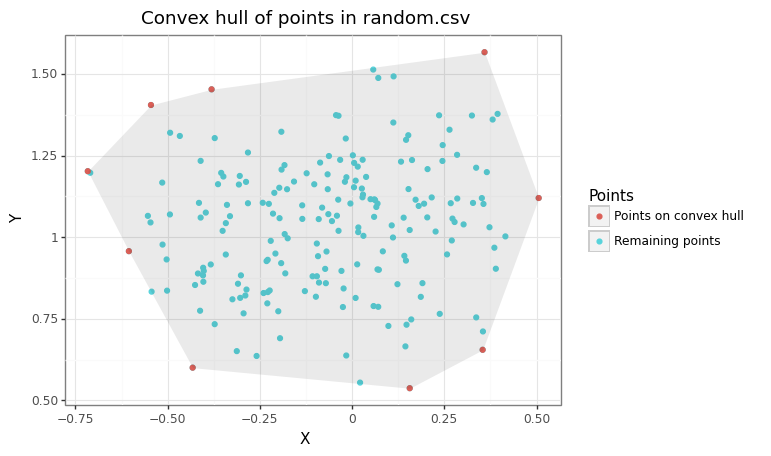


Analysis of square data
There are 6 points in the set and 5 points on the convex hull.
The points on the convex hull have the following coordinates:
(1.0, 1.0)
(1.0, 2.0)
(1.5, 2.5)
(2.0, 2.0)
(2.0, 1.0)


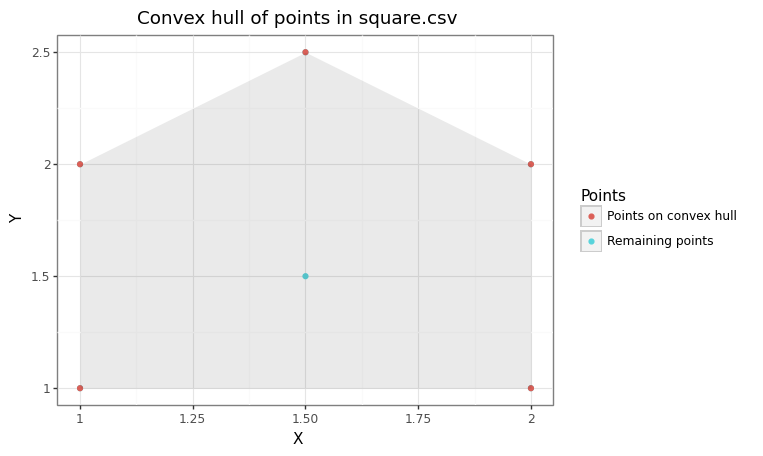


Analysis of line data
There are 3 points in the set and 3 points on the convex hull.
The points on the convex hull have the following coordinates:
(1.0, 1.0)
(2.0, 2.0)
(3.0, 3.0)


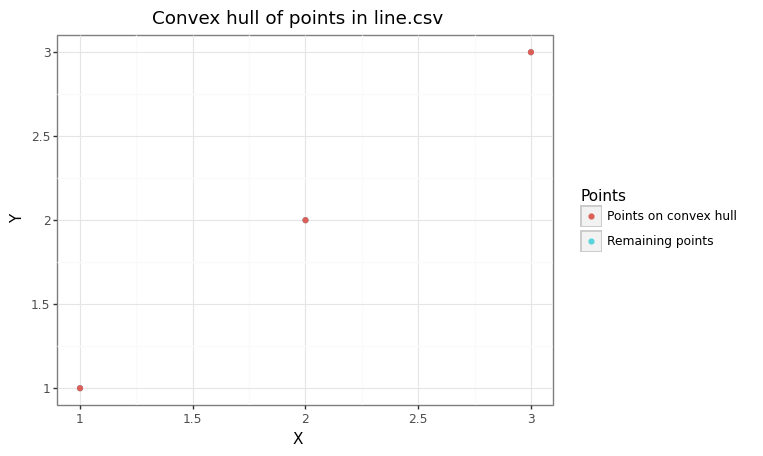


Analysis of pgram data
There are 6 points in the set and 5 points on the convex hull.
The points on the convex hull have the following coordinates:
(1.0, 1.0)
(2.0, 2.0)
(2.5, 2.5)
(3.0, 2.0)
(2.0, 1.0)


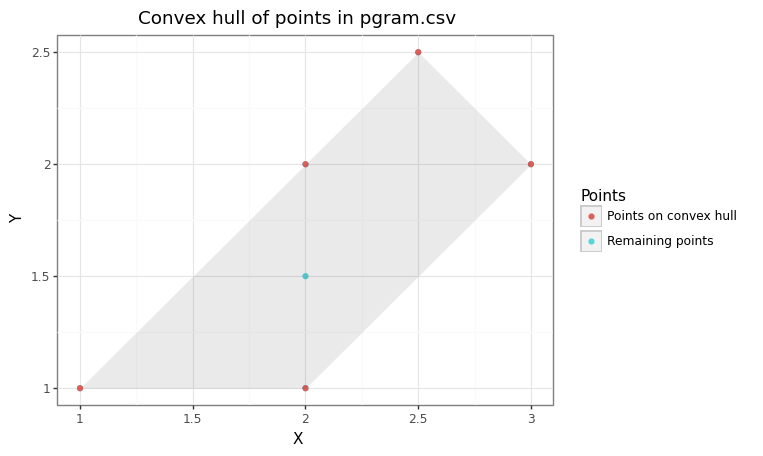


Analysis of pines data
There are 71 points in the set and 14 points on the convex hull.
The points on the convex hull have the following coordinates:
(0.1, 9.9)
(5.3, 9.8)
(7.5, 9.3)
(8.7, 8.7)
(9.2, 8.1)
(9.5, 6.2)
(9.5, 2.3)
(9.4, 1.0)
(9.3, 0.8)
(6.9, 0.4)
(2.0, 0.2)
(1.4, 1.6)
(0.2, 6.2)
(0.1, 7.2)


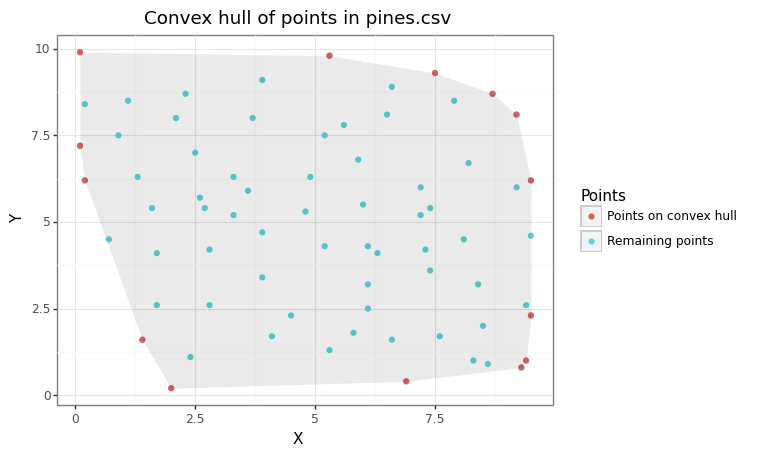

In [4]:
# Do analysis with 'random.csv'
datasets = ['random', 'square', 'line', 'pgram', 'pines']
for data in datasets:
    print('Analysis of ' + data + ' data')
    plot, points, timer, summary = jarvis_march(data)
    print(summary)
    print('The points on the convex hull have the following coordinates:')
    for p in points.convex_hull_points:
        print('(' + str(p.x) + ', ' + str(p.y) + ')')
    print(plot)

### Further analysis

Using the two code cells below, it is possible to generate new sets of points from scratch (not from CSV files) for further testing. I have used this code to test several different sets of points to include edge cases not covered by the 

In [6]:
def jarvis_march_test(points_list):
    """
    Test the Jarvis march algorithm on a list of points

    Parameters
    ----------
    points_list : list
        list of points from the points class

    Returns
    -------
    summary : str
        summary of number of points in the set and on the hull
    points : set_of_points
        set of points with information regarding the convex hull
    plot : ggplot
        plot of the points and the convex hull. 
    """
    
    points = set_of_points(points_list)
    points.find_convex_hull()
    plot = generate_plot(points, points.convex_hull_points, "test_data")
    summary = 'There are ' + str(len(points)) + ' points in the set and ' + str(len(points.convex_hull_points)) + ' points on the convex hull.'
    
    return(summary, points, plot)

There are 4 points in the set and 4 points on the convex hull.
The points on the convex hull have the following coordinates:
(1.0, 1.0)
(3.0, 4.0)
(3.0, 3.0)
(2.0, 2.0)


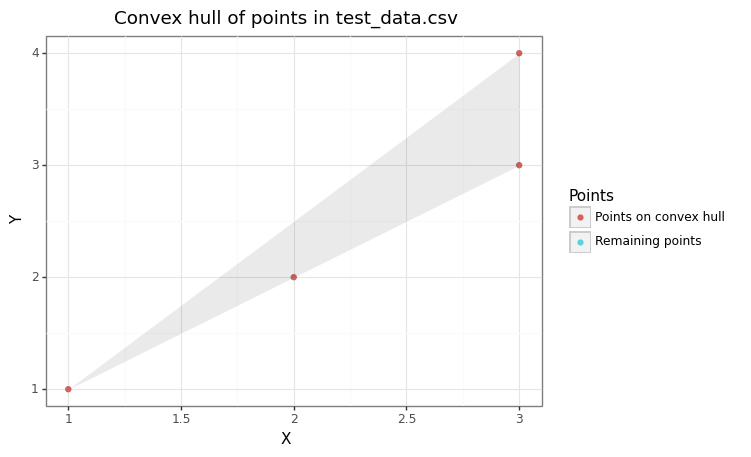


Only two data points to analyse
There are 2 points in the set and 2 points on the convex hull.
The points on the convex hull have the following coordinates:
(1.0, 1.0)
(2.0, 2.0)


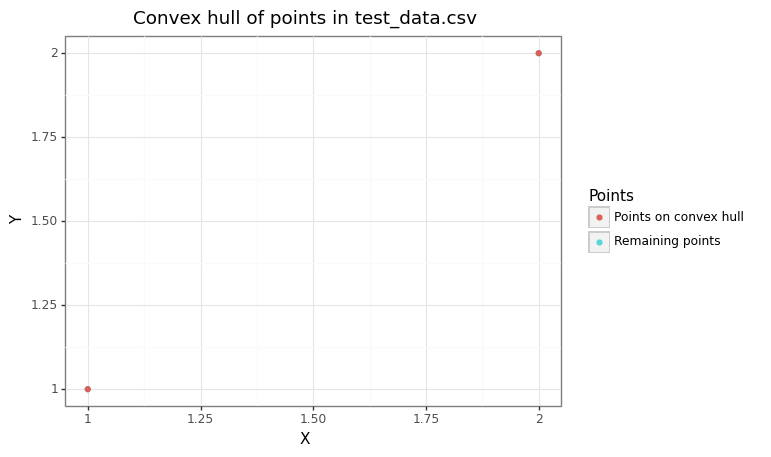


Only one data point to analyse
There are 1 points in the set and 1 points on the convex hull.
The points on the convex hull have the following coordinates:
(1.0, 1.0)


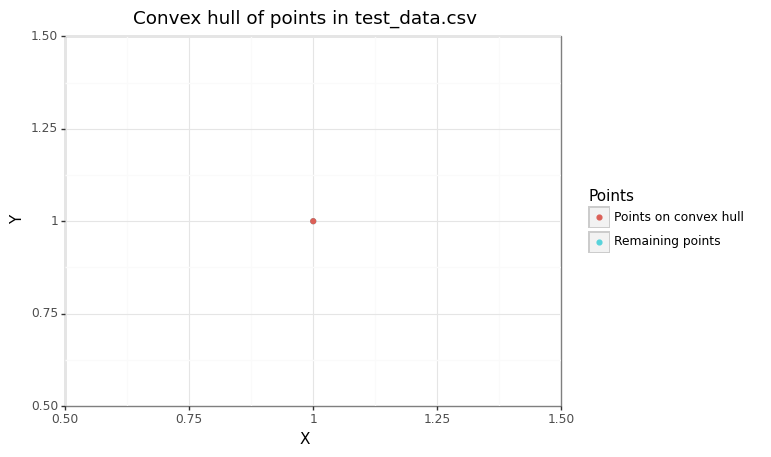


No data points to analyse
There are 0 points in the set and 0 points on the convex hull.
The points on the convex hull have the following coordinates:


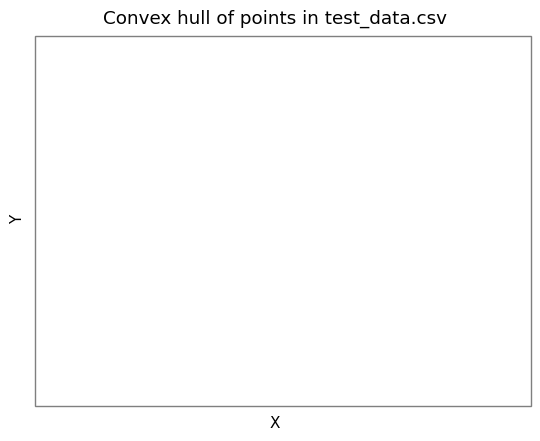

In [7]:
points_list1 = [point(1.0,1.0),point(2.0,2.0),point(3.0,3.0),point(3.0,4.0)]
points_list2 = [point(1.0,1.0),point(2.0,2.0)]
points_list3 = [point(1.0,1.0)]
points_list4 = []

points_lists = [points_list1, points_list2, points_list3, points_list4]

for points_list in points_lists:
    summary, points, plot = jarvis_march_test(points_list)
    print(summary)
    print('The points on the convex hull have the following coordinates:')
    for p in points.convex_hull_points:
        print('(' + str(p.x) + ', ' + str(p.y) + ')')
    print(plot)

### Computational complexity

It is helpful to benchmark the amount of time taken when we have a certain number of points in our set (and on the convex hull), and also to understand how this time will increase as we increase the number of points in the set (or on the convex hull). 

I first notice that within the jarvis_march() function there are three steps which will take a larger amount of time as the number of points grows. Firstly: reading points, then finding the convex hull, then plotting points. 

* Reading points: here the loop is over every line of data, so I would expect this to increase in execution time with $O(n)$. 

* Finding the convex hull: here there are two loops which are nested - one over each point on the convex hull $H$ until it is complete, and within that loop, another loop over all test points (this is all points in the set $S$ except the last point on the convex hull and the initial candidate). I therefore expect this step to increase in execution time with $O(nh)$. 

* Plotting points: here each point in the set is plotted, as well as each point on the convex hull. However, these are done separately so I would expect this step to increase in execution time with $O(n+h)$. 

Since the different steps are expected to scale by different amounts, I focus my attention specifically on finding the convex hull, which I expect to scale with $O(nh)$. I have placed suitable timers in the function and below I take the random data set and time it using an analysis of increasingly large slices of the random data set. The subsequent graph illustrates that indeed, the algorithm scales with $O(nh)$ - if I double the product of the number of points in the set and the number of points on the convex hull, I will, on average, double the amount of time needed to find the convex hull. 

I also note that this algorithm runs very quickly. For $nh \sim 1600$ we have a run time of approx. $0.005$ seconds. 

In [8]:
N = [] # number of points in the set
H = [] # number of points on the convex hull
NH = [] # N*H
T = [] # time needed for analysis

for i in range(3,200):
    plot, points, timer, summary = jarvis_march('random', collect_all = False, collect_amount = i)
    N.append(len(points))
    H.append(len(points.convex_hull_points))
    NH.append(len(points)*len(points.convex_hull_points))
    T.append(timer)
    
df = pd.DataFrame({"n":N, "h":H, "nh":NH, "t (seconds)":T})

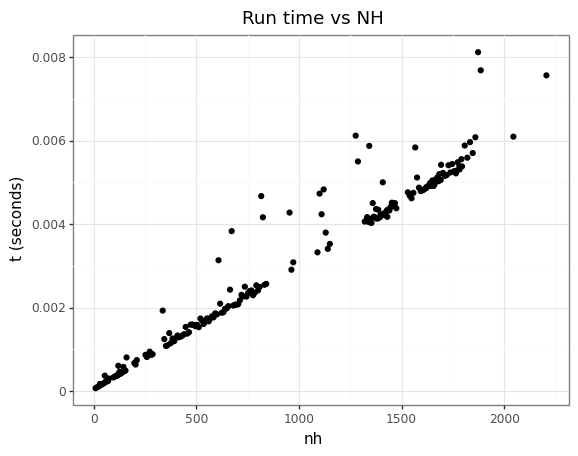

In [9]:
p = ggplot(df,aes(x='nh',y='t (seconds)'))
p = p + geom_point() 
p = p + ggtitle('Run time vs NH')
p = p + theme_bw()
print(p)

### The 5 R's

**Re-runnable**: I have outlined the python version used to develop and test this script to ensure the best chance of successful re-running by another researcher at some point in the future. 

**Repeatable**: I have controlled the random numbers using a random seed within the jarvis_march() function to ensure that repeated use of this function would yield exactly the same results. In practice, the algorithm would find the same complex hull regardless of the random number stream, but controlling the random numbers is still helpful for debugging purposes and to ensure exact repeatability of the procedure. 

**Reproducibile**: By highlighting the python version used to develop and test this script, I have aided in reproduciblity (a future user may be able to run the code with the same (at the time, old) version that I have used. However, further additions to my code would enhance reproducibility: e.g. version control, unit tests and saving results. 

**Reusable**: I have provided extensive commenting and docstrings in my code, and have also avoided hardcording
 as much as possible. Complete elimination of hardcoding (e.g. random seed choice, column numbers in input data) would improve the reusability of my code.
 
**Replicable**: While I have tried to be as clear as possible with my pseudocode and with my commenting/docstrings, the ability for another researcher to replicate my results exactly has yet to be tested in practice!

### Academic references

Jarvis, R. A. (1973). On the identification of the convex hull of a finite set of points in the plane. *Information
processing letters*, 2(1):18–21.